# Final Project Checkpoint 2

**Travis Tegen - Coursera MSCS 6300** </br>

In [1]:
""" RUN THIS CELL TO GET THE RIGHT FORMATTING """
import requests
from IPython.core.display import HTML
css_file = 'https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/css/cpsc6300.css'
styles = requests.get(css_file).text
HTML(styles)

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import mean_squared_error
from matplotcheck.base import PlotTester
from matplotlib.patches import PathPatch

import seaborn as sns

In [3]:
# Pull in the dataframe produced in Final Project Checkpoint 1
df = pd.read_csv("blossoms.csv")

# remove year because it is not a weather-related measurement, even though
# a year value certainly represents some weather patterns implicitly
df = df.drop(['year'], axis=1)

df.head()

,pbd,avg_tmp_prevdec,avg_tmp_jan,avg_tmp_feb,avg_tmp_mar,precip_prevdec,precip_jan,precip_feb,precip_mar,snow_prevdec,snow_jan,snow_feb,snow_mar,first_frost_to_jan1
0,79,39.3,36.6,39.0,55.5,3.15,2.30,2.29,2.76,0.2,1.8,7.10,0.05,50
1,97,37.9,31.9,38.7,45.3,1.95,5.56,2.86,4.74,5.5,31.5,3.00,6.50,52
2,99,37.6,36.8,32.6,45.3,3.48,4.24,2.19,4.47,1.8,3.1,3.90,6.70,40
3,104,45.0,35.0,34.3,42.6,2.80,3.21,3.05,6.17,1.7,1.0,5.30,9.30,60
4,86,36.5,32.9,43.1,46.4,2.98,4.44,0.98,1.60,0.5,19.7,0.05,0.05,46


### EDA

In [4]:
df.describe()

,pbd,avg_tmp_prevdec,avg_tmp_jan,avg_tmp_feb,avg_tmp_mar,precip_prevdec,precip_jan,precip_feb,precip_mar,snow_prevdec,snow_jan,snow_feb,snow_mar,first_frost_to_jan1
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.00000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,93.240385,39.581731,36.181731,38.468269,46.456731,3.080769,2.96375,2.624904,3.353846,2.556250,5.595192,5.025000,2.344712,49.490385
std,7.565244,4.040974,4.429179,4.240083,3.832938,1.534074,1.38166,1.267683,1.524648,3.882633,6.349587,6.762482,3.548875,13.078549
min,74.000000,27.900000,24.900000,24.600000,35.600000,0.220000,0.31000,0.350000,0.050000,0.000000,0.050000,0.000000,0.000000,10.000000
25%,88.000000,36.825000,33.225000,36.450000,43.675000,1.987500,2.11750,1.815000,2.222500,0.050000,1.300000,0.200000,0.050000,41.500000
50%,94.000000,39.700000,35.700000,38.450000,46.400000,2.930000,2.67000,2.460000,3.405000,0.650000,3.400000,2.800000,0.400000,50.000000
75%,99.000000,42.150000,39.350000,41.475000,48.800000,4.110000,3.57000,3.247500,4.222500,3.000000,7.800000,6.600000,3.850000,58.000000
max,108.000000,51.200000,47.900000,47.700000,56.800000,6.790000,7.83000,6.980000,8.450000,16.600000,31.500000,32.100000,17.100000,73.000000


The dataset looks to be in great shape. None of the columns are missing values, and none of the columns appear to have suspicious ranges or averages. I thought, "Did first frost really occur only 10 days before Jan 1 one year?" According to NOAA data for Washington, it did in December 2001.

All feature variables are continuous, meaning no dummy columns need to be added. The response variable, PBD, could be considered discrete since it corresponds to a day number of the year. However, for this project, I'll consider PBD to be a numeric value to predict because it grows and shrinks with fluctuations in the feature variables, and isn't discrete like "day of the week" was in the bike rentals lab for example.

One interesting EDA point from the df.describe() is the PBD ranges from 74 to 108, which is a 34 day range, or barely over a month. It's widely believed that cooler temperatures result in later blossoms while warmer temperatures result in earlier blossoms. In this project, I'll explore the temperatures, but I'm excited to see if the other variables of precipitation and first frost timing will reveal more nuances to answering the PBD question.

The data may need to be scaled later on if I try a polynomial model, but I plan to try a simple Linear Regression model first. Some of the features have different ranges such as temperature and precipitation. Amusingly, the range of numbers covered by the first frost variable is actually not too different than those of the temperature variables.

To get started with visualizations, I will do a correlation matrix like we have done in labs to see which features seem to have a relationship. I am most interested in the features that seem to influence PBD because that is the response variable.

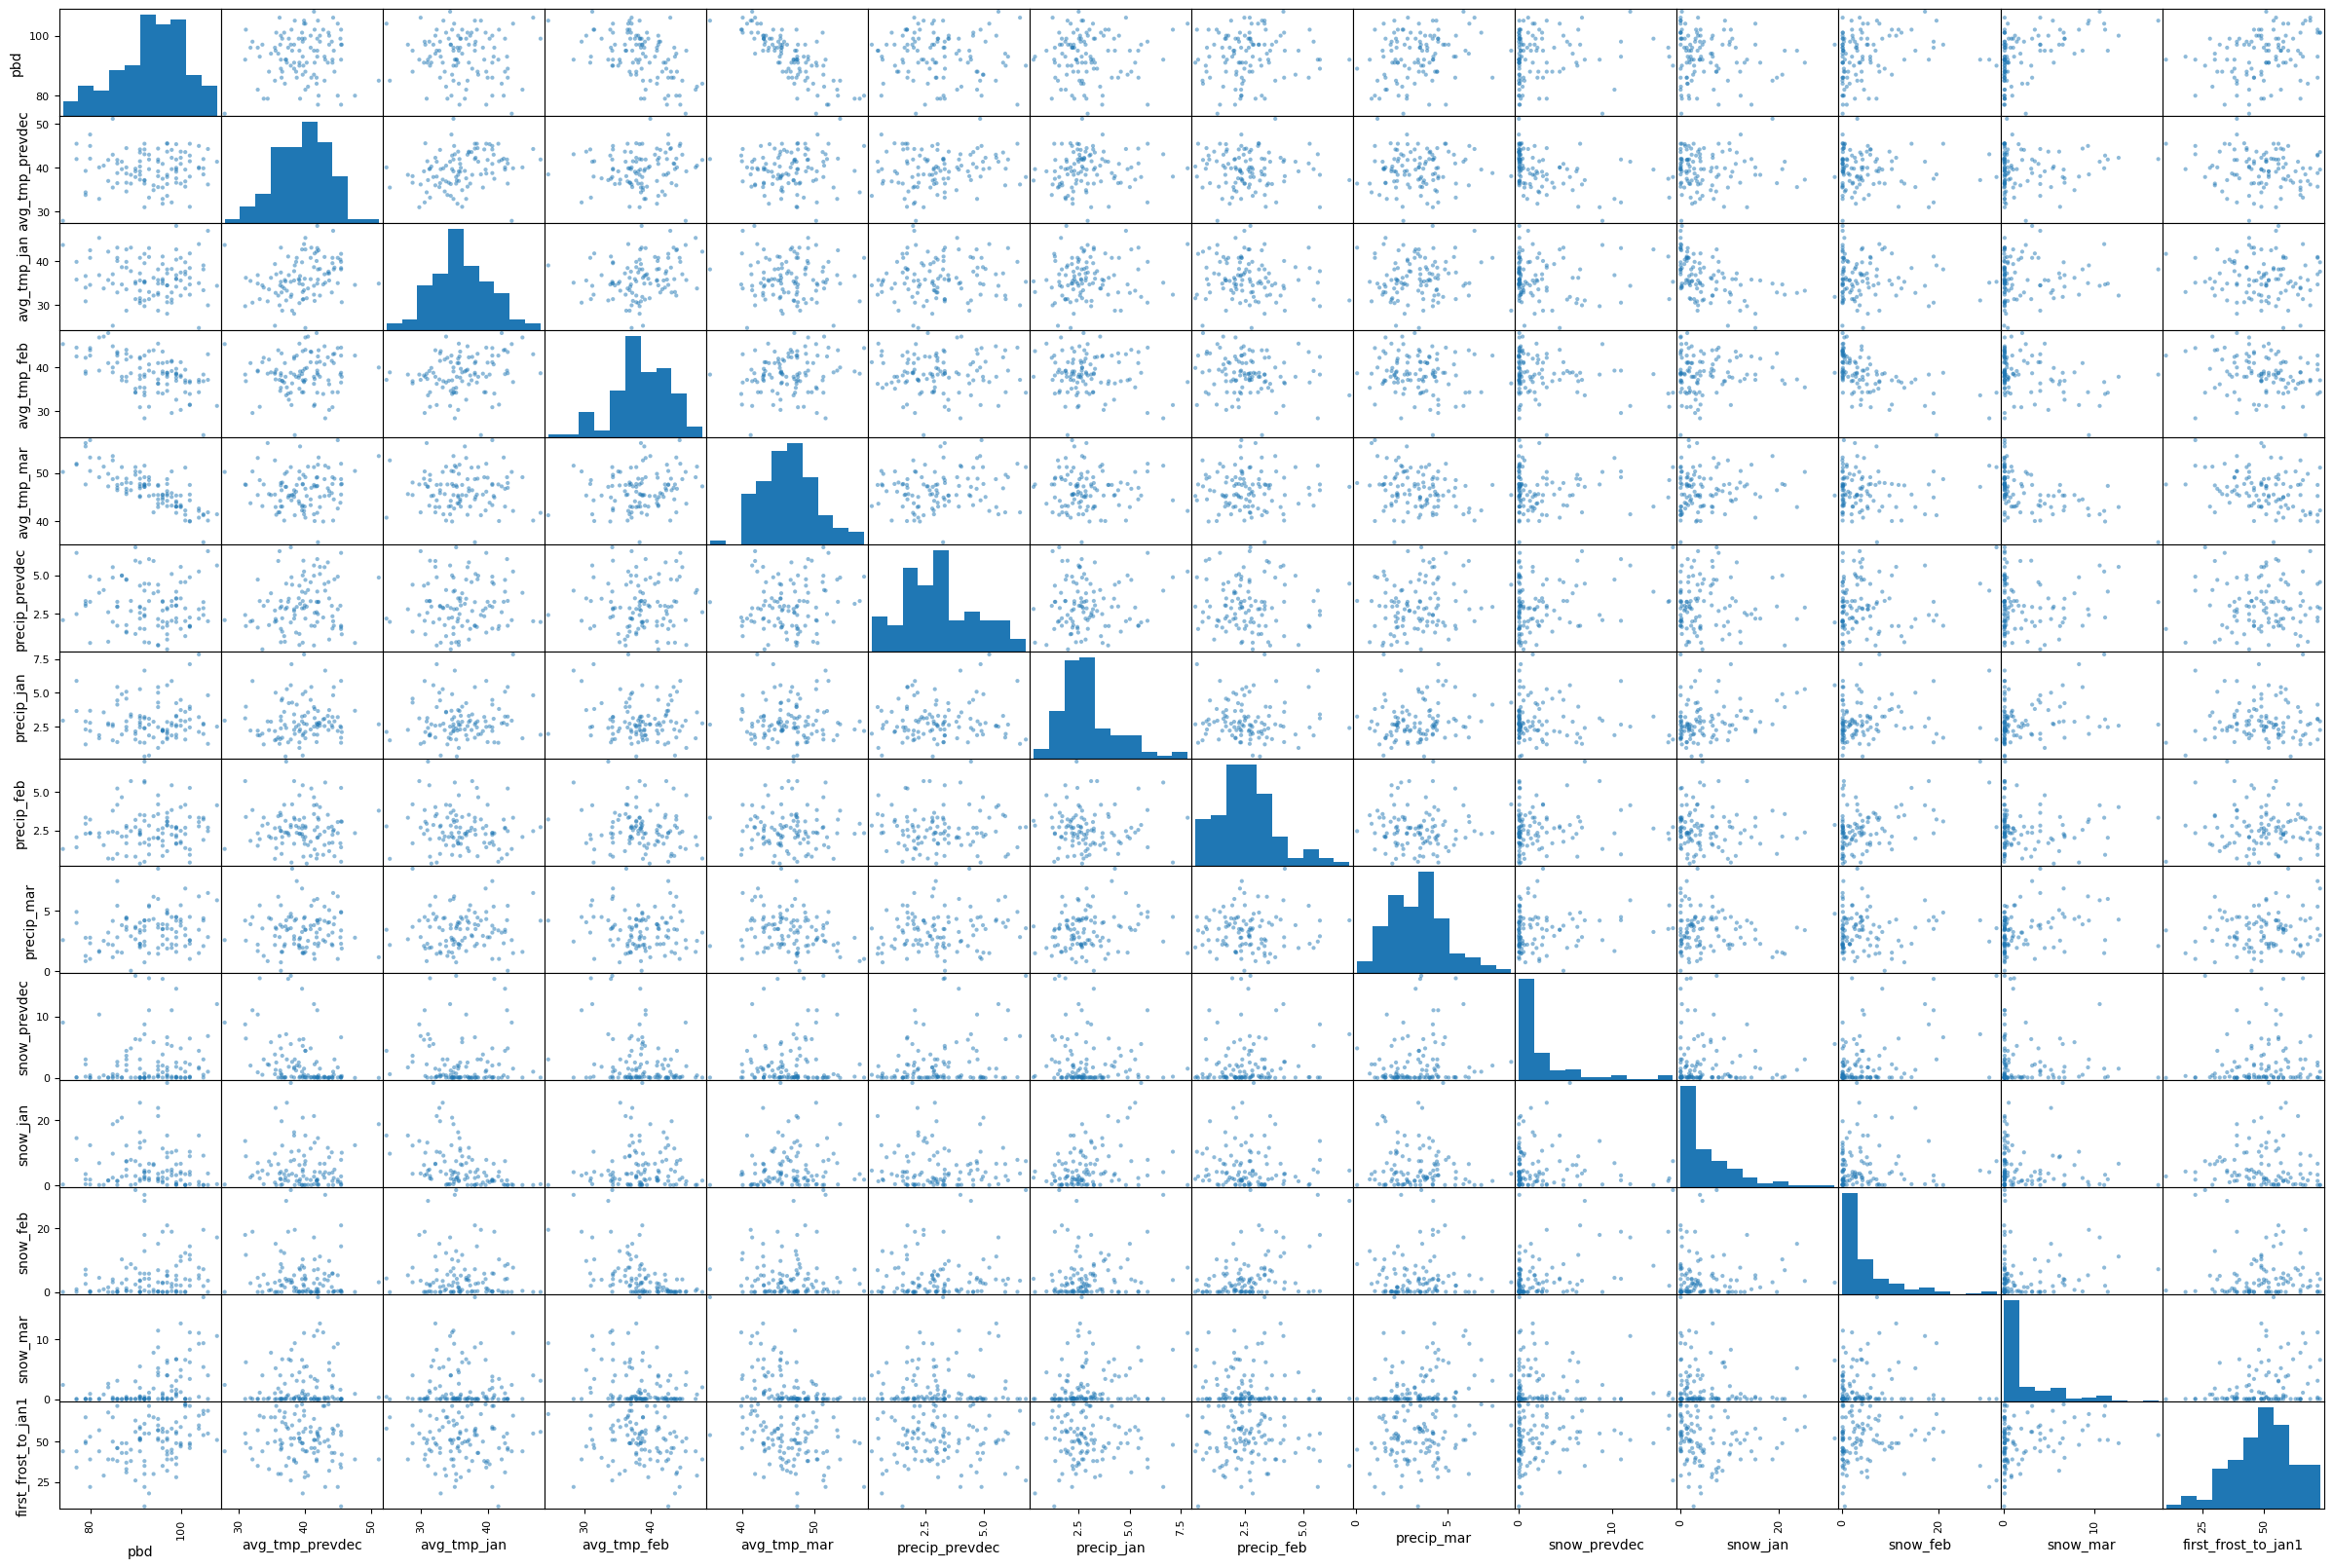

In [5]:
scatter_matrix(df, figsize=(30,20))
plt.show()

Visually, there seems to be a loose correlation between pbd and the February temperatures, which sharpens up a lot in March. This makes sense because the blossoms happen in either March or April. The only other vaguely correlating feature I notice from this visualization is perhaps the pbd vs first frost.

A correlation heatmap like we did in one of our labs will be useful for seeing if I missed anything:

<AxesSubplot: >

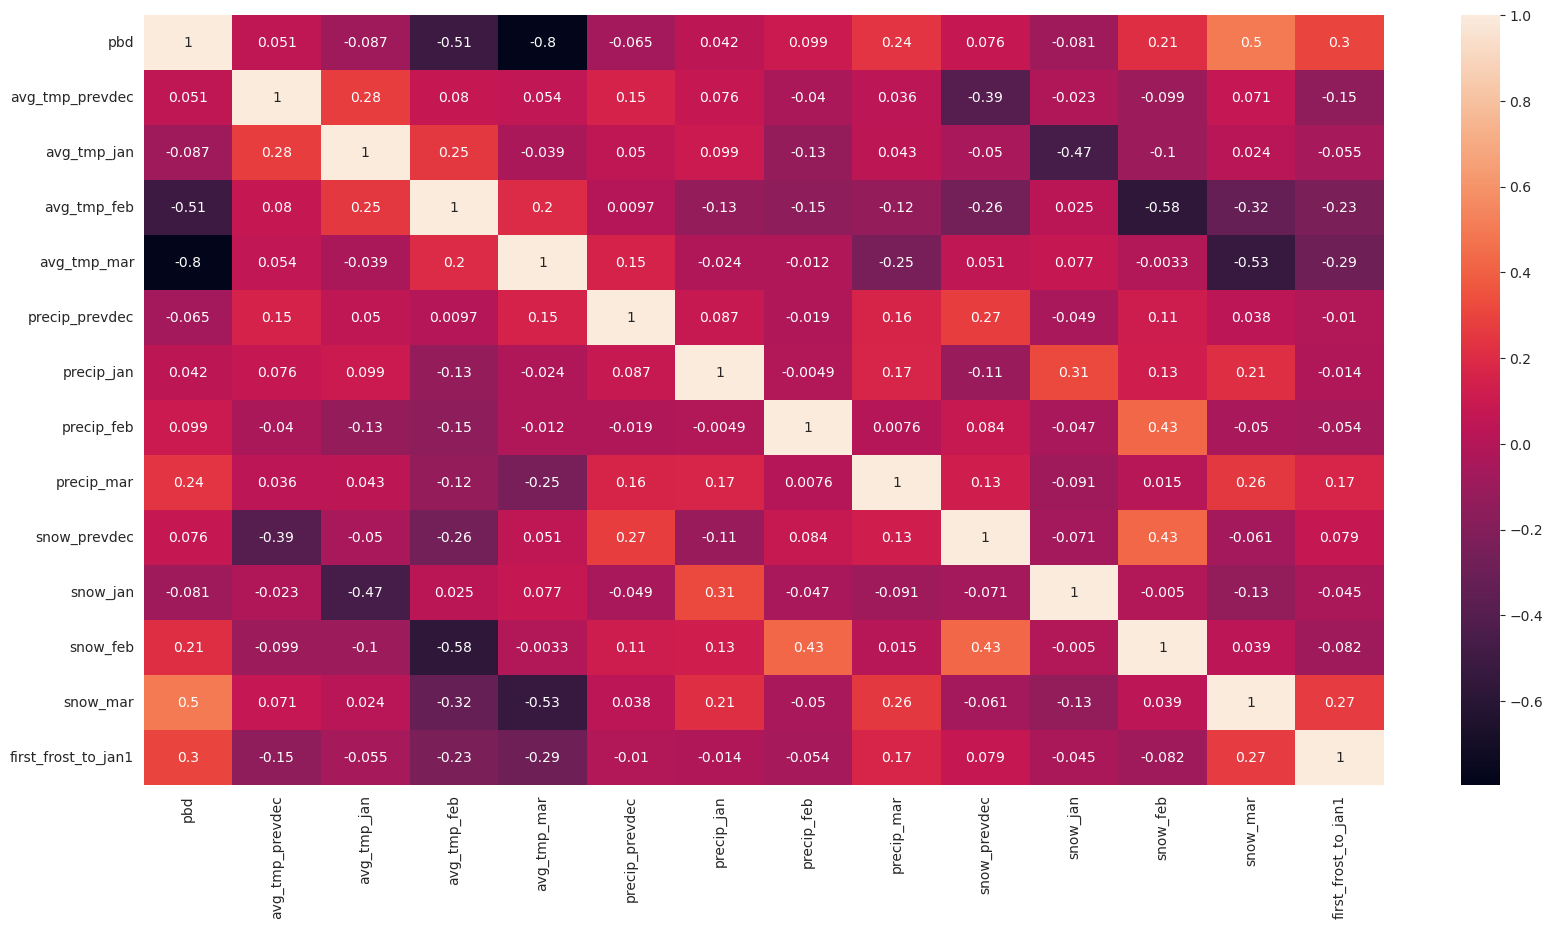

In [6]:
sns.set_style('whitegrid')
plt.figure(figsize=(20,10)) 
sns.heatmap(df.corr(), annot=True) 

The heatmap confirms the correlation between pbd and February/March temperatures. It also reveals that the third strongest feature correlation with PBD is actually the snowfall in March, with the fourth strongest correlation being the first frost timing that had stuck out to me in the previous chart.

### Model Selection

As this course has covered, a simple linear regression model is a reasonable place to start when dealing with a continuous response variable and a dataset where there appears to be a linear relationship between some of the variables, and some linear relationships can be seen in the scatter matrix above. Linear regression is a great model to try first with the data because as Lab 6 stated, it is a common baseline model, and "it's simple, fast, and easily interpretable."

A second model that could apply to predicting a continous variable like PBD is KNN. KNN is compatible with a dataset of continuous features like this project's dataset. As this course covered, KNN would not try to model a line through the feature space, but would instead look for close neighbors in the feature space to make a prediction based on those neighbors' PBDs. For this portion of the project though, I will use Linear Regression.

As mentioned earlier in this report, for the purposes of this project I'm treating PBD response variable as a continuous variable. I'll start by peeling off the pbd variable to be the y values, splitting the data into a 25/75 test train split, fitting a linear regression model, and seeing how the model performs based upon r-squared and MSE. I'll also examine the residuals on the unseen data.

In [7]:
X = df.drop('pbd', axis=1)
y = df.pbd
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

regression = LinearRegression()
regression.fit(X_train, y_train)
r2 = regression.score(X_test, y_test)

predicted_y = regression.predict(X_test)

mse_train = mean_squared_error(y_train, regression.predict(X_train))
mse_test = mean_squared_error(y_test, predicted_y)

print(f"***Simple Linear Regression Performance***")
print()
print(f"R^2: {r2}")
print(f"MSE Train: {mse_train}")
print(f"MSE Test: {mse_test}")
print()

residuals = abs(y_test - predicted_y)
print(f"Avg PBD residual (in days): {residuals.mean()}")
print(f"Min PBD residual (in days): {residuals.min()}")
print(f"Max PBD residual (in days): {residuals.max()}")

***Simple Linear Regression Performance***

R^2: 0.8505881902735751
MSE Train: 13.221992686240382
MSE Test: 7.232769321727113

Avg PBD residual (in days): 2.271122860224238
Min PBD residual (in days): 0.26552275799127756
Max PBD residual (in days): 5.557152740043406


The graph below visualizes how the model performed when predicting the PBD of each year in the unseen test data by illustrating the how many days off each prediction was. Given that the range of PBDs in the original dataset is 34 days, and the biggest residual is 5.6 days, it seems like this simple linear regression model performed well. It did significantly better than random guessing would have: the average residual was 2.2 days and smallest residuals were a fraction of a day at 0.27.

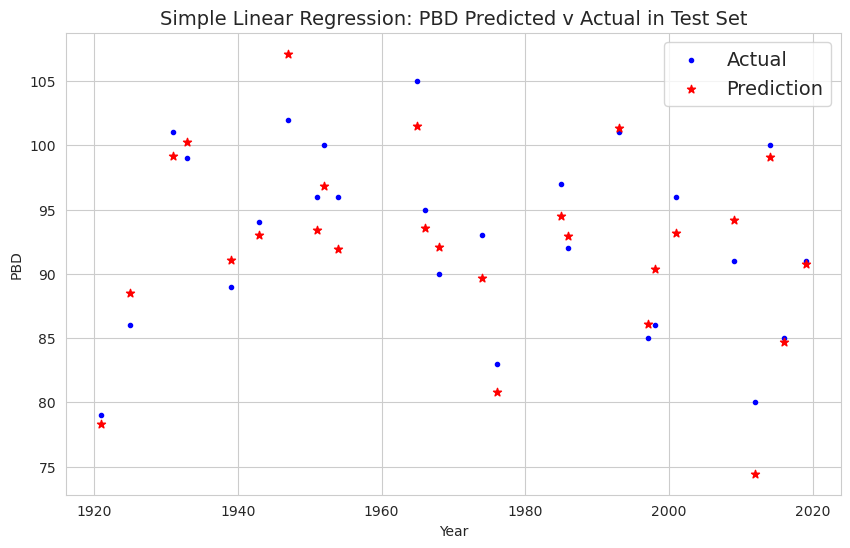

In [8]:
x_vals_for_graph = X_test.index.to_numpy() + 1921

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(x_vals_for_graph, y_test, marker=".", c='b', label='Actual')
ax.scatter(x_vals_for_graph, predicted_y, marker="*", c='r', label='Prediction')    
ax.set_title('Simple Linear Regression: PBD Predicted v Actual in Test Set', fontsize=14)
ax.set_ylabel('PBD')
ax.set_xlabel('Year')
ax.legend(loc='best', fontsize=14)

plt.show()

Part of this report's assignment is to state how the error rate could be explained to the stakeholders of this project's main question. As I mentioned in the previous report, the stakeholders who want to know when the Peak Bloom Date will occur could be the people planning the Washington DC Cherry Blossom festival or it could simply be tourists who want to plan a trip to see the trees at their most beautiful time. One good high-level explanation of the model's error rate would be to show the stakeholders the graph and to tell them, "This model's worst guess is about 5 days off, and its best guess is basically the correct day. It is off by about 2 days on average." The stakeholders would probably know best whether 2 days will make or break the prediction's usefulness. To the stakeholders, it might be the case that being early is better than being late or vice versa.